## Part 2: Solving for MNL parameters in Julia

Max Kapur | <a href="https://www.maxkapur.com/">maxkapur.com</a>

Given school's cutoffs, as percentile values indicating the worst student they will accept, and school's capacities, as estimated from past enrollment, we try to determine the underlying MNL parameters $\delta$ that produce such a market at equilibrium. We assume that the total number of students in the market equals the total demand, or number of enrollees at all the schools

Internally, I work with $\gamma \equiv \exp \delta$, then convert back.

I use the JuMP Julia interface to the Ipopt nonlinear programming solver.

In [1]:
using DataFrames
using CSV
using JuMP
using Ipopt
using Plots

Read in the preprocessed data and peek at which universities were most and least selective.

In [2]:
stats = DataFrame(CSV.File("admitstats.csv"))
sort!(stats, :cutoff)

# Delete a bunch of schools to make the problem more tractable.
# You can comment this out if you have time and lots of RAM.
delete!(stats, filter(x->x % 12 != 0, 1:size(stats)[1]))

demand = stats[!, :demand]
cutoff = stats[!, :cutoff]
display(first(stats, 5))
display(last(stats, 5))
println("Total number of schools: $(size(stats)[1])")

,name,demand,cutoff
,String,Int64,Float64
1,Saint Augustine's University,327,0.02
2,Pennsylvania State University-Penn State Schuylkill,248,0.03
3,Nyack College,264,0.04
4,University of Pikeville,386,0.05
5,Texas Southern University,1110,0.05


,name,demand,cutoff
,String,Int64,Float64
1,University of Wisconsin-Madison,6279,0.81
2,University of Rochester,1472,0.86
3,Claremont McKenna College,337,0.88
4,Pomona College,397,0.91
5,Princeton University,1285,0.94


Total number of schools: 98


Do the optimization. The demand for each school is a function of the preferability parameters and the total population, and the value of this function at each school must match the demand indicated in the input data.

In [3]:
function optimize()
    (m, ) = size(cutoff)
    p = vcat(cutoff, 1)

    model = Model(Ipopt.Optimizer)
    set_optimizer_attribute(model, "print_level", 0)
    set_optimizer_attribute(model, "hessian_approximation", "limited-memory")

    @variable(model, γ[1:m], lower_bound=0, upper_bound=1)
    total_pop = sum(demand)

    # Demand for each school must equal that predicted by MNL model.
    @NLconstraint(model, Demand[c in 1:m], 
                    total_pop * γ[c] * sum((p[d+1] - p[d]) / sum(γ[i] for i in 1:d) for d in c:m)
                    == demand[c])
    
    optimize!(model)
    
    δ = exp.(value.(γ))
    return δ
end

optimize (generic function with 1 method)

In [4]:
δ = optimize()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



98-element Array{Float64,1}:
 1.000000002926098
 1.0
 1.0000000003746568
 1.000000005526835
 1.0
 1.0000000029771188
 1.0000000325075353
 1.0
 1.0
 1.0
 1.0000000006478067
 1.0
 1.0
 ⋮
 1.002975711294089
 1.029827844991666
 1.3102129600685595
 1.0329092610109207
 1.3324441747587197
 1.0621474729468623
 1.1995474660922842
 2.680735186687565
 1.4019584178516178
 1.0919340248726614
 1.158977175569277
 2.2568320432286204

In [5]:
stats[!, :preferability] = δ;

Plot the preferability against cutoffs and capacities and see if there are any outliers.

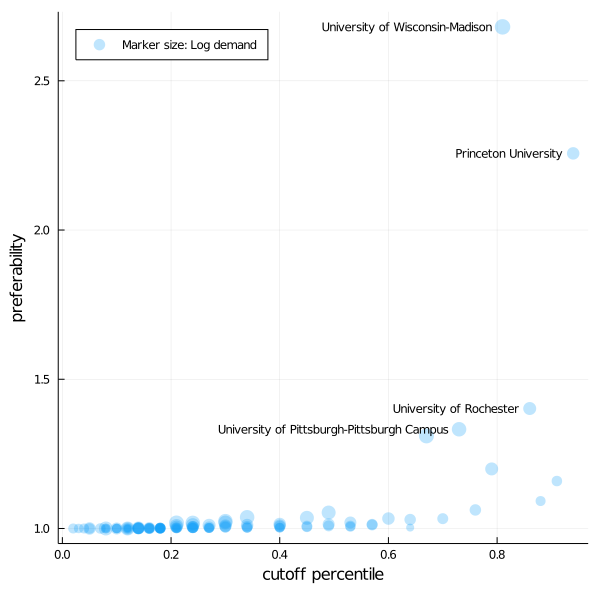

In [8]:
pl = plot(size=(600, 600), xlabel="cutoff percentile", ylabel="preferability", legend=:topleft)

scatter!(pl,
         stats[!, :cutoff],
         stats[!, :preferability],
         marker=:circle,
         ms=log.(stats[!, :demand]),
         msw=0,
         ma=.25,
         label="Marker size: Log demand")

best = sortperm(stats[!, :preferability], rev=true)

for i in 1:4
    annotate!(pl,
          [(stats[best[i], :cutoff] - .02, 
            stats[best[i], :preferability],
            text(stats[best[i], :name], :right, 8))])
end

pl

What do you think? Does it look realistic? 

Recall that we have created this model on the assumption that schools look only at the SAT math score. So, the schools that register as highly preferable here are those that report a combination of high demand *and* high math standards. You might not expect UW Madison to top the list, but it slides into top place because of its combination of fairly high admissions standards and a huge student body. 
By comparison, the score distribution of Princeton's student body is equivalent to the top third of UW Madison's, but the latter has five times as many students overall. 
